In [2]:
import numpy as np
import pandas as pd

import re
import pickle
import random
from tqdm import tqdm_notebook

import torch
from torch import nn
import torch.nn.functional as F

In [4]:
# reproducing same results
SEED = 42
torch.manual_seed(SEED)

# Load Dataset

In [5]:
with open("wikitext-2/wiki-train.txt", "r") as f:
    text = f.readlines()

In [7]:
len(text)

36718

In [8]:
random.sample(text, 10)

[' \n',
 ' Literary critic Mark <unk> Winchell believed that Brooks and Warren \'s criticism of Kilmer \'s poem was chiefly to demonstrate that " it is sometimes possible to learn as much about poetry from bad poems as from good ones . " \n',
 ' \n',
 ' \n',
 ' = = <unk> characteristics = = \n',
 ' \n',
 ' <unk> " <unk> " Davis – mixing \n',
 ' \n',
 ' The Assembly resolved , after some debate , that all the doctrines of the Thirty @-@ Nine articles would need to be proven from the Bible . Assembly members were prone to long speeches and they made slow progress , frustrating the leadership . The eighth of the Thirty @-@ Nine Articles recommended the Apostles \' Creed , <unk> Creed , and <unk> Creed , considered to be basic statements of <unk> , to be received and believed . The Assembly was unable to resolve conflicts between those who would not be bound by creeds and those who wished to retain the existing language that the creeds be " thoroughly received and believed " . The " <unk> 

# Preprocessing Data
## Text Cleaning

In [9]:
# text cleaning
text_clean = []

for line in text:
    # remove everything except alphabets
    line = re.sub("[^a-zA-Z' ]", "", line)
    # convert text to lowercase and remove extra spaces
    line = line.strip().lower()
    # add cleaned text to the list
    if len(line) > 0:
        text_clean.append(line)

In [10]:
random.sample(text_clean, 10)

["maryland route   md   is a state highway in the us state of maryland  the state highway runs    miles     km  from md  in ceresville north to the pennsylvania state line near taneytown  where the highway continues as pennsylvania route   pa   toward hanover  md  is the main highway between frederick and hanover  the state highway connects the towns of walkersville and woodsboro in northeastern frederick county with keymar and taneytown in northwestern carroll county  md  was blazed as a migration route in the th century and a pair of turnpikes in frederick county in the th century  one of which was the last private toll road in maryland  the state highway  which was originally designated md   was built as a modern highway in frederick county in the mid  s and constructed as francis scott key highway in carroll county in the late s and early s  md  received its modern route number in  as part of a three  route number swap  the state highway 's bypasses of walkersville and woodsboro op

## Find word counts

In [11]:
# get list of all the words
all_words = " ".join(text_clean).split()

words_dict = {}

# add word-count pair to the dictionary
for word in all_words:
    words_dict[word] = words_dict.get(word, 0) + 1

In [12]:
# prepare a dataframe
words_df = pd.DataFrame({'word':list(words_dict.keys()), 'count':list(words_dict.values())})

# sort words by their count in increasing order
words_df = words_df.sort_values(by='count')

# reset dataframe index
words_df.reset_index(inplace=True, drop=True)

In [13]:
# vocabulary size
len(words_df)

27306

In [14]:
words_df.tail()

,word,count
27301,in,44982
27302,and,50735
27303,unk,54625
27304,of,57030
27305,the,130768


# Data Preparation

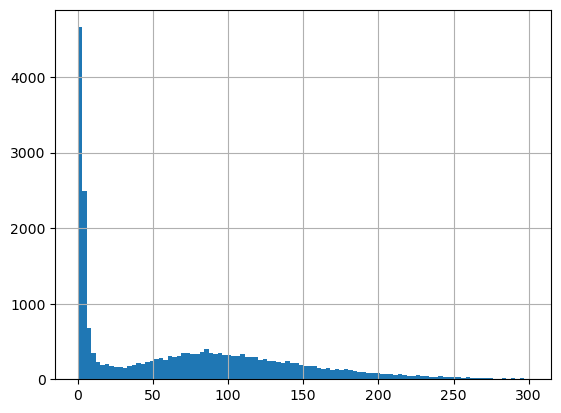

In [15]:
# capture length of all the sequences
text_word_count = []
for sent in text_clean:
    text_word_count.append(len(sent.split()))
        
# plot the sequence lengths
pd.Series(text_word_count).hist(bins=100, range=(0,300));

In [ ]:
# function to create sequences of equal length
def create_seq(text, seq_len=25):
    sequences = []
  
    if len(text.split()) > seq_len:
        for i in range(seq_len, len(text.split())):
            # select sequence of tokens
            seq = text.split()[i-seq_len:i+1]
            # append sequence to the list
            sequences.append(" ".join(seq))
        return sequences
    
    else:
        return [text]

# create sequences of equal length
seqs = []
for text in text_clean:
    seqs.extend(create_seq(text))

In [21]:
seqs[:10]

['valkyria chronicles iii',
 'senj no valkyria unk chronicles japanese lit valkyria of the battlefield commonly referred to as valkyria chronicles iii outside japan is a tactical role playing video',
 'no valkyria unk chronicles japanese lit valkyria of the battlefield commonly referred to as valkyria chronicles iii outside japan is a tactical role playing video game',
 'valkyria unk chronicles japanese lit valkyria of the battlefield commonly referred to as valkyria chronicles iii outside japan is a tactical role playing video game developed',
 'unk chronicles japanese lit valkyria of the battlefield commonly referred to as valkyria chronicles iii outside japan is a tactical role playing video game developed by',
 'chronicles japanese lit valkyria of the battlefield commonly referred to as valkyria chronicles iii outside japan is a tactical role playing video game developed by sega',
 'japanese lit valkyria of the battlefield commonly referred to as valkyria chronicles iii outside jap

In [22]:
# count of sequences
len(seqs)

1297882

In [23]:
# create input and target sequences (x and y)
x = []
y = []

for s in seqs:
  x.append(" ".join(s.split()[:-1]))
  y.append(" ".join(s.split()[1:]))

In [ ]:
# Look at sample input, target pairs
x[36], y[36]

('portable released in january in japan it is the third game in the valkyria series unk the same fusion of tactical and real time gameplay',
 'released in january in japan it is the third game in the valkyria series unk the same fusion of tactical and real time gameplay as')

## Create Token-Integer Mappings

In [26]:
# create integer-to-token mapping
int2token = {}
cnt = 1

for word in set(" ".join(text_clean).split()):
    int2token[cnt] = word
    cnt += 1

# create token-to-integer mapping
token2int = {word: i for i, word in int2token.items()}

In [28]:
int2token[262], token2int['grey']

('plating', 14056)

## Split Data into Train and Validation Sets

In [29]:
# train-validation split
# input sequences
x_tr = x[:1000000]
x_val = x[1000000:]

# target sequences
y_tr = y[:1000000]
y_val = y[1000000:]

## Pad Sequences

<Axes: >

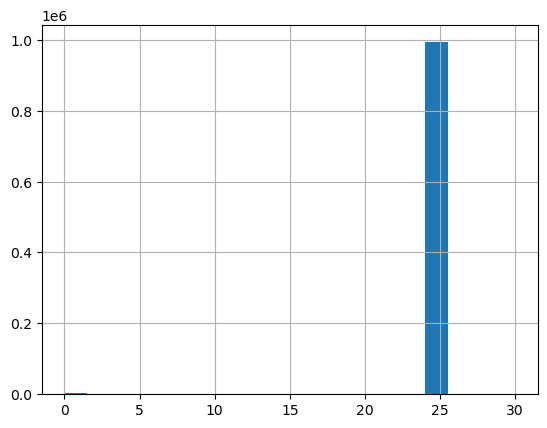

In [ ]:
# plot sequence length in train set
text_word_count = []

for sent in x_tr:
    text_word_count.append(len(sent.split()))

pd.Series(text_word_count).hist(bins=20, range=(0,30));

In [35]:
# based on the plot above
max_text_len = 25

# function to perform padding
def pad_sequence(seq, n):

    # split input sequence into tokens
    seq = seq.split()
    
    # check if no. of tokens in input sequence is less than 'n'
    if len(seq) < n:
        for i in range(n-len(seq)):
            seq.append("<pad>")

    return " ".join(seq)

# pad text sequences (train set)
x_tr_padded = [pad_sequence(s, max_text_len) for s in x_tr]
y_tr_padded = [pad_sequence(s, max_text_len) for s in y_tr]

# pad text sequences (validation set)
x_val_padded = [pad_sequence(s, max_text_len) for s in x_val]
y_val_padded = [pad_sequence(s, max_text_len) for s in y_val]

In [38]:
x_tr_padded[:5]

['valkyria chronicles <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>',
 'senj no valkyria unk chronicles japanese lit valkyria of the battlefield commonly referred to as valkyria chronicles iii outside japan is a tactical role playing',
 'no valkyria unk chronicles japanese lit valkyria of the battlefield commonly referred to as valkyria chronicles iii outside japan is a tactical role playing video',
 'valkyria unk chronicles japanese lit valkyria of the battlefield commonly referred to as valkyria chronicles iii outside japan is a tactical role playing video game',
 'unk chronicles japanese lit valkyria of the battlefield commonly referred to as valkyria chronicles iii outside japan is a tactical role playing video game developed']

In [39]:
# update mapping dictionaries
int2token[0] = "<pad>"
token2int["<pad>"] = 0

# set vocabulary size
vocab_size = len(int2token)

## Convert Text Sequences to Integer Sequences

In [41]:
# function to create integer sequences
def get_integer_seq(seq):
    return [token2int[w] for w in seq.split()]

In [42]:
# convert text sequences to integer sequences
x_tr_int = [get_integer_seq(i) for i in x_tr_padded]
y_tr_int = [get_integer_seq(i) for i in y_tr_padded]

x_val_int = [get_integer_seq(i) for i in x_val_padded]
y_val_int = [get_integer_seq(i) for i in y_val_padded]

In [45]:
x_tr_int[6]

[8887,
 16403,
 15084,
 24340,
 6370,
 18929,
 19355,
 4202,
 4422,
 21553,
 15084,
 20556,
 2992,
 23113,
 10716,
 6035,
 14570,
 5422,
 8944,
 20081,
 20169,
 5094,
 12097,
 15171,
 12760]

In [47]:
y_tr_int[6]

[16403,
 15084,
 24340,
 6370,
 18929,
 19355,
 4202,
 4422,
 21553,
 15084,
 20556,
 2992,
 23113,
 10716,
 6035,
 14570,
 5422,
 8944,
 20081,
 20169,
 5094,
 12097,
 15171,
 12760,
 16252]

In [48]:
# convert lists into numpy arrays
x_tr_int = np.array(x_tr_int)
y_tr_int = np.array(y_tr_int)

x_val_int = np.array(x_val_int)
y_val_int = np.array(y_val_int)

x_tr_int.shape, y_tr_int.shape, x_val_int.shape, y_val_int.shape

((1000000, 25), (1000000, 25), (297882, 25), (297882, 25))

# Model Building
## Define Model Architecture

In [ ]:
# define model architecture

## embedding layer: 
##    input dim = vocab_size, 
##    ouput dim = 200

## LSTM layer:
##    input dim = 200
##    hidden units = 256
##    layers = 2
##    output dim = 256

## Dropout Layer
##    input dim = 256
##    output dim = 256

## fully connected layer
##    input dim = 256
##    ouput dim = vocab_size

class WordLSTM(nn.Module):
      
  def __init__(self, n_hidden=256, n_layers=2, drop_prob=0.3, lr=0.001):
    super().__init__()
    self.drop_prob = drop_prob
    self.n_layers = n_layers
    self.n_hidden = n_hidden
    self.lr = lr
    
    self.emb_layer = nn.Embedding(vocab_size, 200)

    ## define the LSTM
    # input data is of shape (batch size, sequence length, no. of features)...
    # ...therefore we need batch_first=True
    self.lstm = nn.LSTM(200, n_hidden, n_layers, batch_first=True)
    
    ## define a dropout layer
    self.dropout = nn.Dropout(drop_prob)
    
    ## define the fully-connected layer
    self.fc = nn.Linear(n_hidden, vocab_size)      
  
  def forward(self, x, hidden):
    ''' Forward pass through the network. 
        These inputs are x, and the hidden/cell state is `hidden`. '''

    ## pass input through embedding layer
    embedded = self.emb_layer(x)     
    
    ## Get the outputs and the new hidden state from the lstm
    lstm_output, hidden = self.lstm(embedded, hidden)
    
    ## pass through a dropout layer
    out = self.dropout(lstm_output)
    
    ## reshape the tensor to the shape (batch-size*sequence length, hidden units)
    out = out.reshape(-1, self.n_hidden)

    ## put "out" through the fully-connected layer
    out = self.fc(out)

    # return the final output and the hidden state
    return out, hidden
    
    
  def init_hidden(self, batch_size):
    ''' Initializes hidden state '''
    # Create two new tensors with sizes n_layers x batch_size x n_hidden,
    # initialized to zero, for hidden state and cell state of LSTM
    weight = next(self.parameters()).data

    if (torch.cuda.is_available()):
      hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda(),
                weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda())
    else:
      hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_(),
                weight.new(self.n_layers, batch_size, self.n_hidden).zero_())
    
    return hidden

In [ ]:
# define and print the net
net = WordLSTM()
print(net)

In [ ]:
# function to generate batches
def get_batches(arr_x, arr_y, batch_size):
  # iterate through the arrays
  prv = 0
  
  for n in range(batch_size, arr_x.shape[0], batch_size):
    # batch of input sequences
    x = arr_x[prv:n,:]

    # batch of target sequences
    y = arr_y[prv:n,:]

    prv = n
    
    yield x, y